# Preparazione dataset
Nel presente notebook vengono illustrati i vari passaggi impiegati per la creazione dei dataset utilizzati nel progetto. I nostri obiettivi principali sono due:

* **1** Classificazione delle zone con il maggior consumo energetico nell'area urbana di Trento: Utilizzando metodi di classificazione, vogliamo identificare le zone con i consumi più elevati nei giorni infrasettimanali.

* **2** Regressione per la previsione dei consumi energetici: Utilizzando i dati dei giorni precedenti, intendiamo prevedere i consumi energetici per la provincia di Trento e per il comune di Trento.
    
Durante la fase di classificazione e regressione, considereremo tre fasce orarie distinte: "giorno" (dalle 9:00 alle 18:00), "notte" (dalle 18:00 alle 24:00) e "18-19" (dalle 18:00 alle 19:00). Saranno commentate e argomentate le differenze riscontrate nei risultati ottenuti per le tre fasce orarie.

Inoltre, è importante sottolineare che questo notebook verrà utilizzato due volte, una per la creazione del dataset relativo al mese di novembre e l'altra per il mese di dicembre. Successivamente, i dataset saranno uniti in notebook successivi.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gp
from datetime import datetime
from datetime import date
import ydata_profiling as yp
import seaborn as sns


Iniziamo importando due dataset. Il primo, chiamato set_df, contiene i consumi delle linee elettriche di tutto il Trentino. La scala temporale utilizzata è di 10 minuti e i dati coprono l'intero mese di novembre e dicembre. Questo dataset fornisce informazioni dettagliate sui consumi energetici delle linee elettriche nell'area.

Il secondo dataset, denominato lines_df, contiene informazioni sulle zone del Trentino in cui sono presenti ubicazioni. Ogni zona è identificata da uno squareid. Inoltre, a ogni linea elettrica sono associati uno o più squareid, indicando quali ubicazioni utilizzano quella specifica linea elettrica. Questo dataset fornisce un collegamento tra le linee elettriche e le zone geografiche coinvolte.

In [2]:
set_df = pd.read_csv("./data_trentino/raw/SET-nov-2013.csv")
lines_df=pd.read_csv("./data_trentino/raw/line.csv")


Successivamente, trasformiamo la colonna 'DATE' in parametri continui. Estraiamo il giorno del mese ('DAY'), il minuto corrente ('MINUTE') e il giorno della settimana ('DAY_ID'). Questi parametri ci permetteranno di considerare la variabilità temporale nei consumi energetici, inclusi i possibili pattern giornalieri e settimanali.

In [3]:
set_df["DAY"] = pd.to_datetime(set_df["DATE"]).dt.day
set_df["MINUTE"] = pd.to_datetime(set_df["DATE"]).dt.hour*60+pd.to_datetime(set_df["DATE"]).dt.minute
set_df["DAY_ID"] = pd.to_datetime(set_df["DATE"]).dt.day_of_week
del set_df["DATE"]
set_df

,LINESET,POWER,DAY,MINUTE,DAY_ID
0,DG1000420,37.439999,1,0,4
1,DG1000420,37.439999,1,10,4
2,DG1000420,36.000000,1,20,4
3,DG1000420,35.279999,1,30,4
4,DG1000420,35.279999,1,40,4
...,...,...,...,...,...
794513,DG1056626,46.549999,30,1390,5
794514,DG1056626,44.650002,30,1400,5
794515,DG1056626,44.599998,30,1410,5
794516,DG1056626,43.700001,30,1420,5


A questo punto calcoliamo quante ubicazioni ci sono in ogni squareid e quante ubicazioni sono collegate ad ogni singola linea elettrica

In [4]:
ubline_df = lines_df.groupby("LINESET")["NR_UBICAZIONI"].sum().reset_index()
ubline_df = ubline_df.rename(columns={"NR_UBICAZIONI": "LINE_UBICAZIONI"})
set_df = pd.merge(ubline_df, set_df, on="LINESET")

In [5]:
ub_df = lines_df.groupby("SQUAREID")["NR_UBICAZIONI"].sum().reset_index()
ub_df = ub_df.rename(columns={"NR_UBICAZIONI": "SQUARE_UBICAZIONI"})

Creiamo un dataset chiamato final_df contenente tutte le informazioni ottenute

In [6]:
lines_df=pd.merge(lines_df,ub_df,on="SQUAREID")
final_df=pd.merge(lines_df,set_df,on="LINESET")

Calcoliamo anche a quante linee elettriche è collegata ogni zona

In [7]:
nlines_square = lines_df.groupby("SQUAREID")["LINESET"].size().reset_index()
nlines_square = nlines_square.rename(columns={"LINESET": "NR_LINES"})

Calcoliamo la frazione di potenza utilizzata da ogni squareid per ogni linea elettrica

In [8]:
final_df["FRAC_POW"]=final_df['POWER']*(final_df['NR_UBICAZIONI']/final_df['LINE_UBICAZIONI'])
final_df

,SQUAREID,LINESET,NR_UBICAZIONI,SQUARE_UBICAZIONI,LINE_UBICAZIONI,POWER,DAY,MINUTE,DAY_ID,FRAC_POW
0,155,DG1031221,4,4,1380,35.040001,1,0,4,0.101565
1,155,DG1031221,4,4,1380,30.000000,1,10,4,0.086957
2,155,DG1031221,4,4,1380,32.399998,1,20,4,0.093913
3,155,DG1031221,4,4,1380,30.840000,1,30,4,0.089391
4,155,DG1031221,4,4,1380,30.599998,1,40,4,0.088696
...,...,...,...,...,...,...,...,...,...,...
10928875,10984,DG1013504,2,2,74,160.225006,30,1390,5,4.330406
10928876,10984,DG1013504,2,2,74,161.699997,30,1400,5,4.370270
10928877,10984,DG1013504,2,2,74,159.600006,30,1410,5,4.313514
10928878,10984,DG1013504,2,2,74,161.600006,30,1420,5,4.367568


La normalizzazione si effettua raggrupando il dataset sommando i contributi della frazione di potenza in ogni squareid

In [9]:
df_train = final_df.groupby(["SQUAREID","DAY","DAY_ID","MINUTE","SQUARE_UBICAZIONI"])[["FRAC_POW"]].sum().reset_index()
df_train=df_train.rename(columns={"FRAC_POW": "POWER"})
df_train=pd.merge(df_train,nlines_square,on=['SQUAREID'])
df_train

,SQUAREID,DAY,DAY_ID,MINUTE,SQUARE_UBICAZIONI,POWER,NR_LINES
0,155,1,4,0,4,0.101565,1
1,155,1,4,10,4,0.086957,1
2,155,1,4,20,4,0.093913,1
3,155,1,4,30,4,0.089391,1
4,155,1,4,40,4,0.088696,1
...,...,...,...,...,...,...,...
8566921,11099,30,5,1390,3,0.295767,1
8566922,11099,30,5,1400,3,0.297291,1
8566923,11099,30,5,1410,3,0.287472,1
8566924,11099,30,5,1420,3,0.280530,1


# Ora dell'alba,del tramonto e durata del giorno
Aggiungiamo l'ora dell'alba, del tramonto e la durata del giorno come parametri aggiuntivi. Abbiamo creato due dataset chiamati 'albatramonto', uno per novembre 2013 e l'altro per dicembre 2013. L'ora dell'alba e del tramonto è un parametro che varia durante l'anno e potrebbe influenzare il consumo elettrico nelle diverse fasce orarie considerate.

In [10]:
hour_df=pd.read_csv("./data_trentino/raw/albatramonto-nov-2013.csv")
hour_df["DAWN"] = pd.to_datetime(hour_df["DAWN"]).dt.hour*60+pd.to_datetime(hour_df["DAWN"]).dt.minute
hour_df["SUNSET"] = pd.to_datetime(hour_df["SUNSET"]).dt.hour*60+pd.to_datetime(hour_df["SUNSET"]).dt.minute
hour_df["DAYLENGHT"] = pd.to_datetime(hour_df["DAYLENGHT"]).dt.hour*60+pd.to_datetime(hour_df["DAYLENGHT"]).dt.minute
df_train= df_train.merge(hour_df, on='DAY', how='left')
df_train

,SQUAREID,DAY,DAY_ID,MINUTE,SQUARE_UBICAZIONI,POWER,NR_LINES,DAWN,SUNSET,DAYLENGHT
0,155,1,4,0,4,0.101565,1,417,1020,603
1,155,1,4,10,4,0.086957,1,417,1020,603
2,155,1,4,20,4,0.093913,1,417,1020,603
3,155,1,4,30,4,0.089391,1,417,1020,603
4,155,1,4,40,4,0.088696,1,417,1020,603
...,...,...,...,...,...,...,...,...,...,...
8566921,11099,30,5,1390,3,0.295767,1,456,991,534
8566922,11099,30,5,1400,3,0.297291,1,456,991,534
8566923,11099,30,5,1410,3,0.287472,1,456,991,534
8566924,11099,30,5,1420,3,0.280530,1,456,991,534


# Temperature minime e massime
Successivamente, introduciamo i dati delle temperature minime e massime utilizzando il file JSON 'meteotrentino-weather-station-data'. Da questo dataset, estraiamo le temperature minime e massime delle 36 stazioni presenti in Trentino e le associamo agli squareid più vicini. 
L'associazione delle temperature minime e massime ai squareid ci consente di considerare l'effetto delle condizioni climatiche locali sui consumi energetici nelle diverse zone del Trentino.

In [11]:
from shapely.geometry import Point,Polygon,LineString
temp_df=pd.read_csv("./data_trentino/raw/line.csv")
del temp_df['LINESET']
station_df=temp_df.drop_duplicates('SQUAREID',keep='last')
df_grid = gp.read_file("./data_trentino/raw/trentino-grid.geojson")
df_grid = df_grid.rename(columns={"cellId": "SQUAREID"})
df_grid['geometry']=df_grid['geometry'].centroid
temp_df = station_df.merge(df_grid[['SQUAREID','geometry']],on='SQUAREID',how='left')
temp_df[['SQUAREID','geometry']]

C:\Users\Federico\AppData\Local\Temp\ipykernel_8044\156516737.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_grid['geometry']=df_grid['geometry'].centroid


,SQUAREID,geometry
0,155,POINT (10.92119 45.68640)
1,272,POINT (10.92150 45.69539)
2,273,POINT (10.93434 45.69518)
3,276,POINT (10.97285 45.69452)
4,277,POINT (10.98568 45.69429)
...,...,...
2015,10983,POINT (11.78361 46.49669)
2016,10984,POINT (11.79662 46.49637)
2017,11097,POINT (11.74501 46.50662)
2018,11098,POINT (11.75803 46.50631)


In [12]:
import json
with open("./data_trentino/raw/meteotrentino-weather-station-data.json") as f:
    weather_json = json.load(f)

In [13]:
weather = gp.GeoDataFrame(weather_json['features'])
weather['geometry'] = weather['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))
weather.drop(columns=['geomPoint.geom'],inplace=True)
weather.drop_duplicates(subset='station',keep='first',inplace=True)
weather=weather[['station','geometry']]
weather

C:\Users\Federico\AppData\Local\Temp\ipykernel_8044\243618655.py:2: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  weather['geometry'] = weather['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))


,station,geometry
0,T0071,POINT (10.79583 46.31340)
1,T0032,POINT (11.25372 45.94027)
2,T0096,POINT (11.66458 46.38364)
3,T0074,POINT (10.91841 46.35160)
4,T0101,POINT (11.07973 46.15635)
5,T0118,POINT (11.21802 46.17063)
6,T0129,POINT (11.13565 46.07185)
7,T0236,POINT (11.11886 46.39071)
8,T0135,POINT (11.10131 46.09565)
9,T0139,POINT (11.30223 46.10709)


Associo ad ogni SQUAREID la stazione più vicina

In [14]:
import geopandas as gp
from shapely.geometry import Point
from scipy.spatial import cKDTree


temp_df['geometry'] = temp_df['geometry'].apply(lambda geom: Point(geom.x, geom.y))
weather['geometry'] = weather['geometry'].apply(lambda geom: Point(geom.x, geom.y))


weather = weather.reset_index(drop=True)

tree = cKDTree(list(zip(weather['geometry'].apply(lambda geom: geom.x), weather['geometry'].apply(lambda geom: geom.y))))

distances, indices = tree.query(list(zip(temp_df['geometry'].apply(lambda geom: geom.x), temp_df['geometry'].apply(lambda geom: geom.y))), k=1)

temp_df['station'] = weather.loc[indices, 'station'].values

temp_df

,SQUAREID,NR_UBICAZIONI,geometry,station
0,155,4,POINT (10.921193351453743 45.68639714371787),T0405
1,272,72,POINT (10.921501481446724 45.69539290883363),T0405
2,273,21,POINT (10.93433838066539 45.69517620882651),T0405
3,276,34,POINT (10.972848192225122 45.69451745983337),T0405
4,277,3,POINT (10.985684497470725 45.694294993990646),T0405
...,...,...,...,...
2015,10983,5,POINT (11.783605576966147 46.496685077109554),T0437
2016,10984,2,POINT (11.796621666875987 46.49636732616585),T0437
2017,11097,1,POINT (11.745008722662964 46.506618662575015),T0437
2018,11098,6,POINT (11.758027608959734 46.50630525265036),T0437


In [15]:
with open("./data_trentino/raw/meteotrentino-weather-station-data.json") as f:
    weather_json = json.load(f)
weather = gp.GeoDataFrame(weather_json['features'])

Si selezionano solo i dati meteo riguardanti novembre o dicembre

In [16]:
weather=weather[['station','date','minTemperature','maxTemperature']]
weather = weather[(weather["date"] < '2013-12-01')]
#weather = weather[(weather["date"] > '2013-11-30')]
weather["DAY"] = pd.to_datetime(weather["date"]).dt.day
del weather["date"]
weather

#weather

,station,minTemperature,maxTemperature,DAY
0,T0071,4.5,12.3,1
1,T0032,6.5,10.2,1
2,T0096,6.5,11.8,1
3,T0074,6.2,13.6,1
4,T0101,11.1,16.3,1
...,...,...,...,...
1075,T0428,-2.9,6.1,30
1076,T0431,-2.5,1.9,30
1078,T0437,-6.9,0.8,30
1079,T0450,-7.9,-0.2,30


Associamo ad ogni squareid la temperatura minima e massima

In [17]:
temp_df
temp_df=temp_df[['SQUAREID','station']]
temp_df= temp_df.merge(weather, on='station', how='left')

del temp_df["station"]
temp_df

,SQUAREID,minTemperature,maxTemperature,DAY
0,155,9.2,18.9,1
1,155,11.8,15.9,2
2,155,11.0,19.2,3
3,155,8.6,11.5,4
4,155,7.4,16.6,5
...,...,...,...,...
60524,11099,-11.8,-3.7,26
60525,11099,-12.4,-5.0,27
60526,11099,-9.6,-0.4,28
60527,11099,-7.1,1.2,29


Infine uniamo il dataset creato con i dati precedenti

In [18]:
df_train= df_train.merge(temp_df, on=['SQUAREID','DAY'], how='left')
df_train

,SQUAREID,DAY,DAY_ID,MINUTE,SQUARE_UBICAZIONI,POWER,NR_LINES,DAWN,SUNSET,DAYLENGHT,minTemperature,maxTemperature
0,155,1,4,0,4,0.101565,1,417,1020,603,9.2,18.9
1,155,1,4,10,4,0.086957,1,417,1020,603,9.2,18.9
2,155,1,4,20,4,0.093913,1,417,1020,603,9.2,18.9
3,155,1,4,30,4,0.089391,1,417,1020,603,9.2,18.9
4,155,1,4,40,4,0.088696,1,417,1020,603,9.2,18.9
...,...,...,...,...,...,...,...,...,...,...,...,...
8566921,11099,30,5,1390,3,0.295767,1,456,991,534,-6.9,0.8
8566922,11099,30,5,1400,3,0.297291,1,456,991,534,-6.9,0.8
8566923,11099,30,5,1410,3,0.287472,1,456,991,534,-6.9,0.8
8566924,11099,30,5,1420,3,0.280530,1,456,991,534,-6.9,0.8


Quando si lavora con un classificatore o un regressore, potrebbe essere più efficace sostituire un parametro periodico come 'DAYID' con un vettore booleano. In questo caso, il vettore assume il valore 1 nella posizione corrispondente al giorno corrente e 0 in tutte le altre posizioni.

Per implementare questa strategia, introduciamo 7 nuove colonne nel nostro dataset, ognuna delle quali rappresenta un giorno della settimana. Ad esempio, possiamo avere colonne chiamate 'LUN', 'MAR', 'MER' e così via.
L'utilizzo di un vettore booleano per rappresentare i giorni della settimana offre diversi vantaggi. Innanzitutto, semplifica la rappresentazione dei giorni, consentendo un'indicazione chiara e diretta del giorno corrente. Inoltre, elimina la necessità di gestire il parametro periodico 'DAYID' e le sue eventuali implicazioni nella fase di modellazione

In [19]:
dummies = pd.get_dummies(df_train['DAY_ID'], prefix='', prefix_sep='')
days_of_week = ['LUN', 'MAR', 'MER', 'GIO', 'VEN', 'SAB', 'DOM']
dummies.columns = days_of_week

df_train = pd.concat([df_train, dummies], axis=1)

df_train

,SQUAREID,DAY,DAY_ID,MINUTE,SQUARE_UBICAZIONI,POWER,NR_LINES,DAWN,SUNSET,DAYLENGHT,minTemperature,maxTemperature,LUN,MAR,MER,GIO,VEN,SAB,DOM
0,155,1,4,0,4,0.101565,1,417,1020,603,9.2,18.9,0,0,0,0,1,0,0
1,155,1,4,10,4,0.086957,1,417,1020,603,9.2,18.9,0,0,0,0,1,0,0
2,155,1,4,20,4,0.093913,1,417,1020,603,9.2,18.9,0,0,0,0,1,0,0
3,155,1,4,30,4,0.089391,1,417,1020,603,9.2,18.9,0,0,0,0,1,0,0
4,155,1,4,40,4,0.088696,1,417,1020,603,9.2,18.9,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8566921,11099,30,5,1390,3,0.295767,1,456,991,534,-6.9,0.8,0,0,0,0,0,1,0
8566922,11099,30,5,1400,3,0.297291,1,456,991,534,-6.9,0.8,0,0,0,0,0,1,0
8566923,11099,30,5,1410,3,0.287472,1,456,991,534,-6.9,0.8,0,0,0,0,0,1,0
8566924,11099,30,5,1420,3,0.280530,1,456,991,534,-6.9,0.8,0,0,0,0,0,1,0


# Visualizzazione dati
A questo punto creiamo un dataset con la potenza media di ogni giorno, per ogni zona considerata

In [20]:
df_mean = df_train.groupby(["SQUAREID",'DAY','DAY_ID','LUN', 'MAR', 'MER', 'GIO', 'VEN', 'SAB', 'DOM',"SQUARE_UBICAZIONI",'NR_LINES','DAWN','SUNSET','DAYLENGHT','minTemperature','maxTemperature'])["POWER"].mean().reset_index()
df_mean.sort_values(by=['POWER'],inplace=True)
df_mean

,SQUAREID,DAY,DAY_ID,LUN,MAR,MER,GIO,VEN,SAB,DOM,SQUARE_UBICAZIONI,NR_LINES,DAWN,SUNSET,DAYLENGHT,minTemperature,maxTemperature,POWER
31592,5537,3,6,0,0,0,0,0,0,1,34,2,419,1017,597,8.5,14.8,-46.870523
31590,5537,1,4,0,0,0,0,1,0,0,34,2,417,1020,603,9.0,13.4,-45.382025
48171,8212,3,6,0,0,0,0,0,0,1,278,1,419,1017,597,2.5,11.2,-43.189328
48169,8212,1,4,0,0,0,0,1,0,0,278,1,417,1020,603,4.5,12.3,-42.601840
31599,5537,10,6,0,0,0,0,0,0,1,34,2,429,1008,578,3.2,8.2,-39.956405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27230,5201,21,3,0,0,0,1,0,0,0,1288,7,445,997,552,0.9,8.2,160.438605
27238,5201,29,4,0,0,0,0,1,0,0,1288,7,455,991,536,-1.6,6.2,161.076853
27235,5201,26,1,0,1,0,0,0,0,0,1288,7,451,993,541,2.4,6.7,161.549674
27236,5201,27,2,0,0,1,0,0,0,0,1288,7,453,992,539,-0.3,4.9,164.106378


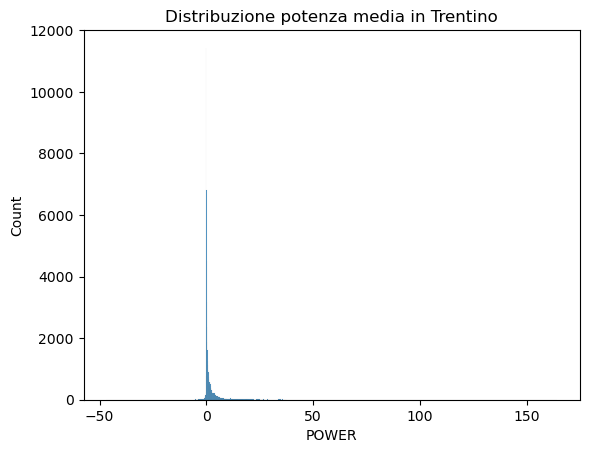

In [21]:
import matplotlib.pyplot as plt
sns.histplot(df_mean['POWER'])
plt.title('Distribuzione potenza media in Trentino')
plt.show()

Osservando la distribuzione dei consumi energetici nelle varie zone, possiamo osservare che la maggior parte delle zone presenta un consumo medio relativamente basso, espresso in kilowatt. Questo indica che la maggioranza delle zone consuma una quantità limitata di energia elettrica.

Inoltre, è interessante notare la presenza di zone con valori di consumo energetico negativi. Un valore negativo indica che queste zone stanno in realtà immettendo più energia nella rete elettrica di quanto ne stanno consumando. Questo fenomeno può essere attribuito a diverse ragioni, tra cui la presenza di centrali energetiche come le centrali idroelettriche.

Calcoliamo la varianza di ogni zona e importiamo un file json contenente la mappa del Trentino

In [22]:
df_var_nov = df_train.groupby(["SQUAREID"])["POWER"].var().reset_index()
df_var_nov = df_var_nov.rename(columns={"POWER": "POW_VAR"})
df_mean_nov = df_train.groupby(["SQUAREID"])["POWER"].mean().reset_index()
df_mean_nov = df_mean_nov.rename(columns={"POWER": "POW_MEAN"})

In [23]:
df_grid = gp.read_file("./data_trentino/raw/trentino-grid.geojson")
df_grid = df_grid.rename(columns={"cellId": "SQUAREID"})

In [24]:
df_grid = df_grid.merge(df_var_nov[['SQUAREID','POW_VAR']],on='SQUAREID',how='left')
df_grid = df_grid.merge(df_mean_nov[['SQUAREID','POW_MEAN']],on='SQUAREID',how='left')

Text(0.5, 1.0, 'Potenza media Novembre')

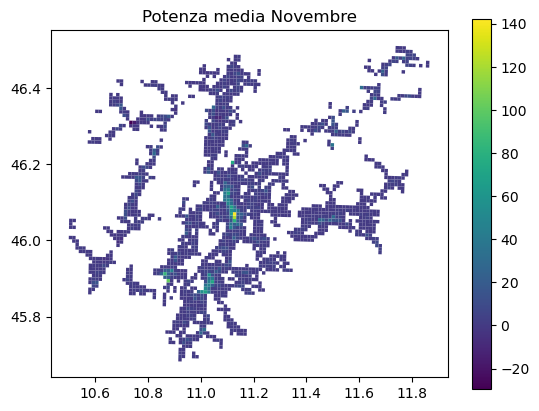

In [25]:
ax=df_grid.plot(column='POW_MEAN',legend=True)
ax.set_title('Potenza media Novembre')

Il consumo medio più elevato nel Trentino si riscontra nelle principali zone urbane, tra cui Trento, Rovereto, Riva del Garda, Arco, Ala e Borgo Valsugana. Queste città sono caratterizzate da una maggiore densità demografica e una vasta gamma di attività commerciali, industriali e residenziali. Di conseguenza, il loro consumo energetico è naturalmente più elevato rispetto ad altre aree meno dense o rurali.

Text(0.5, 1.0, 'Varianza Novembre')

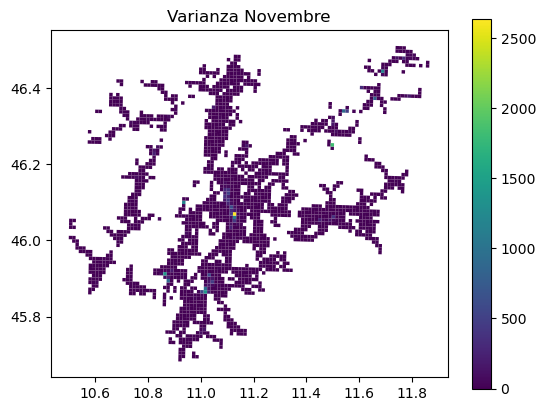

In [26]:
ax=df_grid.plot(column='POW_VAR',legend=True)
ax.set_title('Varianza Novembre')

Guardando alla varianza dei consumi, possiamo osservare come questa sia più elevata nelle zone con una maggiore densità abitativa, come ad esempio nei centri urbani più grandi. Questo si riflette anche nella potenza media, che tende ad essere più alta in tali aree.

Per valutare la correlazione tra le due grandezze, possiamo effettuare un plot che mostri la relazione tra varianza e potenza media. Inoltre, calcoliamo anche il coefficiente di correlazione effettiva per ottenere una misura quantitativa della relazione tra le due variabili.

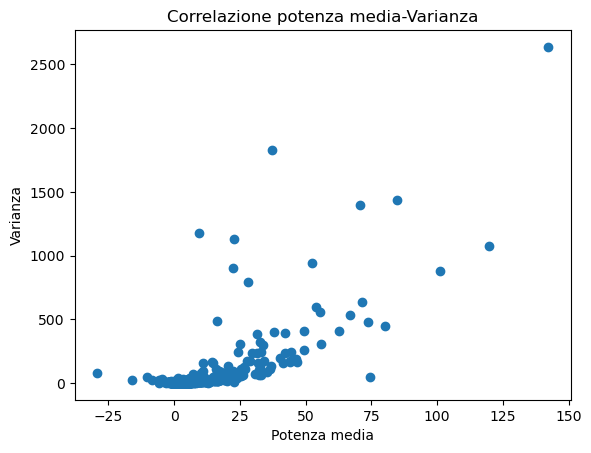

0.7364009120792258


In [27]:
plt.scatter(df_grid['POW_MEAN'],df_grid['POW_VAR'])
plt.xlabel('Potenza media')
plt.ylabel('Varianza')
plt.title('Correlazione potenza media-Varianza')
plt.show()
print(df_grid['POW_MEAN'].corr(df_grid['POW_VAR']))

Osservando i dati, possiamo notare che la varianza dei consumi e la potenza media mostrano una correlazione positiva di circa 0.74. Questo valore di correlazione suggerisce l'esistenza di una relazione moderatamente forte tra le due grandezze.
L'interpretazione di questa correlazione potrebbe essere la seguente: Nelle zone con una maggiore variazione dei consumi energetici, è più probabile che si verifichino anche valori più elevati di potenza media. Ciò potrebbe essere dovuto a diversi fattori, come la presenza di attività industriali o residenziali più intensive dal punto di vista energetico in tali aree.

Analizzando con attenzione le zone con potenza media negativa, possiamo notare che queste si concentrano in aree specifiche che sono caratterizzate dalla presenza di centrali idroelettriche. Un esempio di questa situazione è la di Santa Giustina nella val di Non.

<AxesSubplot:title={'center':'Zone con potenza media negativa'}>

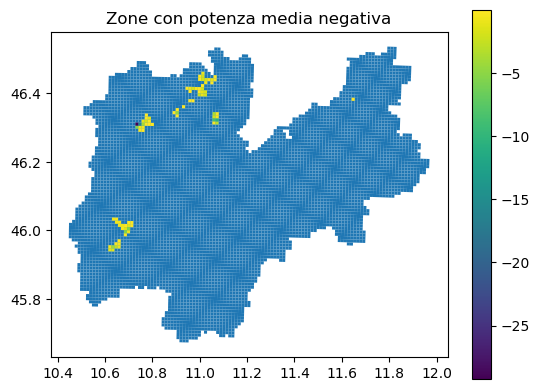

In [28]:
ax = df_grid.plot()
date_mask = (df_grid['POW_MEAN'] < 0)
ax.set_title('Zone con potenza media negativa')
df_grid[date_mask].plot(column='POW_MEAN',ax=ax,legend=True)

# Zona urbana di Trento
In questa sezione ci concentriamo sulla selezione della zona che corrisponde all'area urbana di Trento. Per individuare correttamente questa zona, abbiamo delimitato l'area utilizzando Google Maps, identificando i vertici geografici che racchiudono il comune di Trento. Durante questo processo, abbiamo prestato particolare attenzione a escludere le zone industriali, come quella compresa tra Trento nord e Lavis, al fine di focalizzarci esclusivamente sull'area urbana di Trento.

Successivamente, utilizzando la mappa geografica del Trentino, abbiamo calcolato il punto centrale di ogni squareid.
Per determinare l'appartenenza, abbiamo verificato se il punto centrale del squareid era incluso all'interno del poligono che rappresenta l'area urbana di Trento.

In [29]:
df_grid['centroid']=df_grid['geometry'].centroid
df_grid

C:\Users\Federico\AppData\Local\Temp\ipykernel_8044\1630510222.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_grid['centroid']=df_grid['geometry'].centroid


,SQUAREID,geometry,POW_VAR,POW_MEAN,centroid
0,38,"POLYGON ((10.91462 45.68201, 10.92746 45.68179...",NaN,NaN,POINT (10.92089 45.67740)
1,39,"POLYGON ((10.92746 45.68179, 10.94029 45.68157...",NaN,NaN,POINT (10.93372 45.67718)
2,40,"POLYGON ((10.94029 45.68157, 10.95312 45.68136...",NaN,NaN,POINT (10.94655 45.67697)
3,154,"POLYGON ((10.90209 45.69122, 10.91493 45.69100...",NaN,NaN,POINT (10.90836 45.68661)
4,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",0.00184,0.12833,POINT (10.92119 45.68640)
...,...,...,...,...,...
6570,11336,"POLYGON ((11.80475 46.52767, 11.81777 46.52735...",NaN,NaN,POINT (11.81103 46.52301)
6571,11337,"POLYGON ((11.81777 46.52735, 11.83080 46.52703...",NaN,NaN,POINT (11.82405 46.52269)
6572,11452,"POLYGON ((11.79219 46.53698, 11.80521 46.53666...",NaN,NaN,POINT (11.79847 46.53232)
6573,11453,"POLYGON ((11.80521 46.53666, 11.81824 46.53634...",NaN,NaN,POINT (11.81149 46.53200)


A questo punto inseriamo le coordinate trovate tramite Google Maps

In [30]:
coord=[(11.12641,46.04101), (11.16880,46.06938), ( 11.16236,46.08841), ( 11.10449,46.11013),(11.09849,46.06282)]
coord

[(11.12641, 46.04101),
 (11.1688, 46.06938),
 (11.16236, 46.08841),
 (11.10449, 46.11013),
 (11.09849, 46.06282)]

In [31]:
import shapely.geometry as sh
polygon_trento=sh.polygon.Polygon(coord)


Creiamo una colonna booleana 'TRENTO'

In [32]:
df_grid['TRENTO'] = polygon_trento.contains(df_grid['centroid'])*1

Visualizziamo la zona considerata per vedere se corrisponde effettivamente alla zona urbana di Trento

Text(0.5, 1.0, 'Zona urbana Trento')

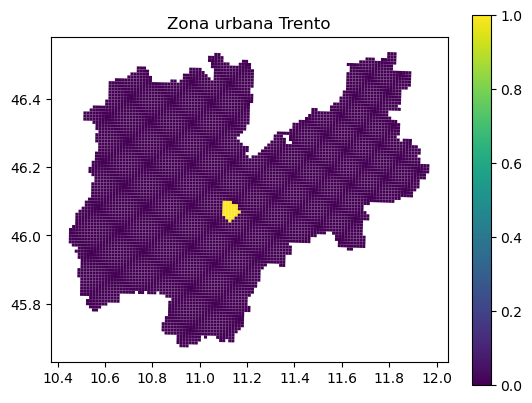

In [33]:
df_point = pd.DataFrame
ax=df_grid.plot(column='TRENTO',legend=True)
ax.set_title('Zona urbana Trento')

In [34]:
df_grid[df_grid['TRENTO']==1]

,SQUAREID,geometry,POW_VAR,POW_MEAN,centroid,TRENTO
2166,4850,"POLYGON ((11.12110 46.04739, 11.13402 46.04715...",19.920849,19.207339,POINT (11.12738 46.04277),1
2259,4966,"POLYGON ((11.10852 46.05662, 11.12144 46.05638...",23.096738,14.909163,POINT (11.11481 46.05201),1
2260,4967,"POLYGON ((11.12144 46.05638, 11.13436 46.05614...",447.517084,80.280910,POINT (11.12773 46.05177),1
2261,4968,"POLYGON ((11.13436 46.05614, 11.14728 46.05590...",23.147878,20.068261,POINT (11.14065 46.05152),1
2351,5082,"POLYGON ((11.09595 46.06585, 11.10887 46.06562...",20.597547,8.923858,POINT (11.10224 46.06124),1
2352,5083,"POLYGON ((11.10887 46.06562, 11.12179 46.06538...",71.224878,30.904911,POINT (11.11516 46.06100),1
2353,5084,"POLYGON ((11.12179 46.06538, 11.13471 46.06514...",1077.925413,119.713368,POINT (11.12808 46.06076),1
2354,5085,"POLYGON ((11.13471 46.06514, 11.14763 46.06489...",22.207043,14.185554,POINT (11.14100 46.06052),1
2355,5086,"POLYGON ((11.14763 46.06489, 11.16055 46.06465...",16.042287,16.149589,POINT (11.15391 46.06028),1
2445,5199,"POLYGON ((11.09629 46.07485, 11.10921 46.07461...",4.095605,5.212295,POINT (11.10258 46.07023),1


In [35]:
df_trento=df_grid[['SQUAREID','TRENTO','POW_MEAN']]
df_trento.dropna(inplace=True)
df_trento

C:\Users\Federico\AppData\Local\Temp\ipykernel_8044\1012865115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trento.dropna(inplace=True)


,SQUAREID,TRENTO,POW_MEAN
4,155,0,0.128330
11,272,0,2.309941
12,273,0,0.673733
15,276,0,1.184961
16,277,0,0.104555
...,...,...,...
6539,10983,0,3.326474
6540,10984,0,1.330590
6552,11097,0,0.045859
6553,11098,0,0.275154


Uniamo i dati ottenuti con quelli precedenti

In [36]:
df_mean_trento=df_mean.merge(df_trento[['SQUAREID','TRENTO']],on='SQUAREID',how='left')
df_mean_trento

,SQUAREID,DAY,DAY_ID,LUN,MAR,MER,GIO,VEN,SAB,DOM,SQUARE_UBICAZIONI,NR_LINES,DAWN,SUNSET,DAYLENGHT,minTemperature,maxTemperature,POWER,TRENTO
0,5537,3,6,0,0,0,0,0,0,1,34,2,419,1017,597,8.5,14.8,-46.870523,0
1,5537,1,4,0,0,0,0,1,0,0,34,2,417,1020,603,9.0,13.4,-45.382025,0
2,8212,3,6,0,0,0,0,0,0,1,278,1,419,1017,597,2.5,11.2,-43.189328,0
3,8212,1,4,0,0,0,0,1,0,0,278,1,417,1020,603,4.5,12.3,-42.601840,0
4,5537,10,6,0,0,0,0,0,0,1,34,2,429,1008,578,3.2,8.2,-39.956405,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59444,5201,21,3,0,0,0,1,0,0,0,1288,7,445,997,552,0.9,8.2,160.438605,1
59445,5201,29,4,0,0,0,0,1,0,0,1288,7,455,991,536,-1.6,6.2,161.076853,1
59446,5201,26,1,0,1,0,0,0,0,0,1288,7,451,993,541,2.4,6.7,161.549674,1
59447,5201,27,2,0,0,1,0,0,0,0,1288,7,453,992,539,-0.3,4.9,164.106378,1


In [37]:
df_mean_trento=df_mean_trento[df_mean_trento["TRENTO"] == 1]
del df_mean_trento['TRENTO']
df_mean_trento.groupby(["SQUAREID",'DAY','DAY_ID','LUN', 'MAR', 'MER', 'GIO', 'VEN', 'SAB', 'DOM',"SQUARE_UBICAZIONI",'NR_LINES','DAWN','SUNSET','DAYLENGHT','minTemperature','maxTemperature'])["POWER"].mean().reset_index()

,SQUAREID,DAY,DAY_ID,LUN,MAR,MER,GIO,VEN,SAB,DOM,SQUARE_UBICAZIONI,NR_LINES,DAWN,SUNSET,DAYLENGHT,minTemperature,maxTemperature,POWER
0,4850,1,4,0,0,0,0,1,0,0,285,5,417,1020,603,11.7,16.0,16.969336
1,4850,2,5,0,0,0,0,0,1,0,285,5,418,1019,600,11.7,15.2,17.290039
2,4850,3,6,0,0,0,0,0,0,1,285,5,419,1017,597,9.9,18.1,16.626700
3,4850,4,0,1,0,0,0,0,0,0,285,5,421,1016,594,7.4,9.8,19.897254
4,4850,5,1,0,1,0,0,0,0,0,285,5,422,1014,592,7.5,15.4,18.839105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,5552,26,1,0,1,0,0,0,0,0,133,1,451,993,541,2.4,6.7,6.621068
836,5552,27,2,0,0,1,0,0,0,0,133,1,453,992,539,-0.3,4.9,6.690039
837,5552,28,3,0,0,0,1,0,0,0,133,1,454,992,538,-2.6,5.0,6.627188
838,5552,29,4,0,0,0,0,1,0,0,133,1,455,991,536,-1.6,6.2,6.213660


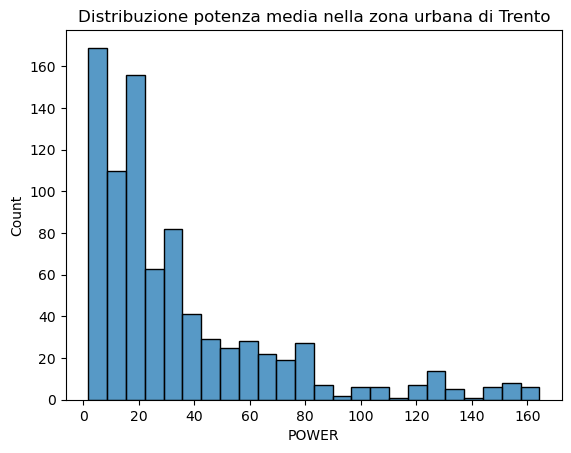

In [38]:
sns.histplot(df_mean_trento['POWER'])
plt.title('Distribuzione potenza media nella zona urbana di Trento')
plt.show()

# Fascia oraria 8-19
Ragruppiamo i dati adesso nella fascia oraria tra le 8 e le 19 e facciamo la media sulla potenza,poi salviamo i dati di tutta la provincia e quelli riguardanti solo la zona urbana di Trento.
Successivamente ripetiamo lo stesso per le fascie 19-24 e 18-19

In [39]:
df_day=df_train[(df_train["MINUTE"] >= 480)&(df_train["MINUTE"] <= 1140)]
df_day=df_day.groupby(["SQUAREID",'DAY','DAY_ID','LUN', 'MAR', 'MER', 'GIO', 'VEN', 'SAB', 'DOM',"SQUARE_UBICAZIONI",'NR_LINES','DAWN','SUNSET','DAYLENGHT','minTemperature','maxTemperature'])["POWER"].mean().reset_index()
df_day

,SQUAREID,DAY,DAY_ID,LUN,MAR,MER,GIO,VEN,SAB,DOM,SQUARE_UBICAZIONI,NR_LINES,DAWN,SUNSET,DAYLENGHT,minTemperature,maxTemperature,POWER
0,155,1,4,0,0,0,0,1,0,0,4,1,417,1020,603,9.2,18.9,0.073531
1,155,2,5,0,0,0,0,0,1,0,4,1,418,1019,600,11.8,15.9,0.129407
2,155,3,6,0,0,0,0,0,0,1,4,1,419,1017,597,11.0,19.2,0.103237
3,155,4,0,1,0,0,0,0,0,0,4,1,421,1016,594,8.6,11.5,0.178362
4,155,5,1,0,1,0,0,0,0,0,4,1,422,1014,592,7.4,16.6,0.109082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59444,11099,26,1,0,1,0,0,0,0,0,3,1,451,993,541,-11.8,-3.7,0.242534
59445,11099,27,2,0,0,1,0,0,0,0,3,1,453,992,539,-12.4,-5.0,0.298340
59446,11099,28,3,0,0,0,1,0,0,0,3,1,454,992,538,-9.6,-0.4,0.297658
59447,11099,29,4,0,0,0,0,1,0,0,3,1,455,991,536,-7.1,1.2,0.313812


In [40]:
df_day_trento=df_day.merge(df_trento[['SQUAREID','TRENTO']],on='SQUAREID',how='left')
df_day_trento=df_day_trento[df_day_trento['TRENTO']==1]
df_day_trento

,SQUAREID,DAY,DAY_ID,LUN,MAR,MER,GIO,VEN,SAB,DOM,SQUARE_UBICAZIONI,NR_LINES,DAWN,SUNSET,DAYLENGHT,minTemperature,maxTemperature,POWER,TRENTO
23040,4850,1,4,0,0,0,0,1,0,0,285,5,417,1020,603,11.7,16.0,18.177452,1
23041,4850,2,5,0,0,0,0,0,1,0,285,5,418,1019,600,11.7,15.2,19.164852,1
23042,4850,3,6,0,0,0,0,0,0,1,285,5,419,1017,597,9.9,18.1,17.756735,1
23043,4850,4,0,1,0,0,0,0,0,0,285,5,421,1016,594,7.4,9.8,23.338705,1
23044,4850,5,1,0,1,0,0,0,0,0,285,5,422,1014,592,7.5,15.4,21.874364,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31915,5552,26,1,0,1,0,0,0,0,0,133,1,451,993,541,2.4,6.7,7.923465,1
31916,5552,27,2,0,0,1,0,0,0,0,133,1,453,992,539,-0.3,4.9,8.064573,1
31917,5552,28,3,0,0,0,1,0,0,0,133,1,454,992,538,-2.6,5.0,7.927466,1
31918,5552,29,4,0,0,0,0,1,0,0,133,1,455,991,536,-1.6,6.2,7.224181,1


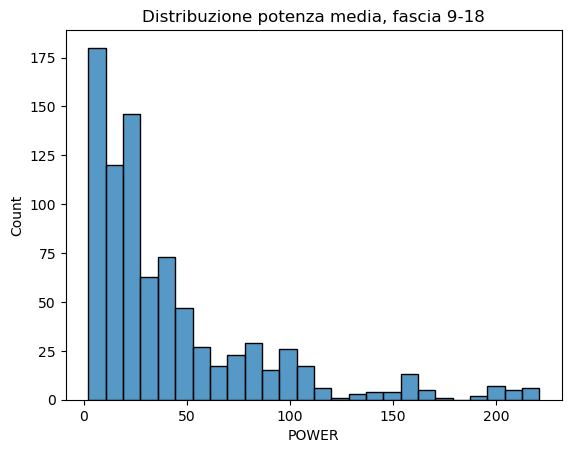

In [41]:
sns.histplot(df_day_trento['POWER'])
plt.title('Distribuzione potenza media, fascia 9-18')
plt.show()

In [42]:
len(df_day_trento[df_day_trento['POWER']>=20])

508

Abbiamo deciso di dividere le zone in urbane e rurali utilizzando una soglia di potenza di 20 kW come criterio discriminante. Questa scelta deriva dal fatto che le zone urbane tendono ad avere un consumo energetico più elevato rispetto alle zone rurali. La soglia di 20 kW rappresenta un valore di potenza significativo, che ci consente di identificare le aree in cui il consumo energetico è tipicamente più alto e che sono quindi considerate zone urbane

In [43]:
df_day_trento['HIGH_POW']=np.where(df_day_trento["POWER"] >= 20, 1, 0)

In [44]:
df_day_trento

,SQUAREID,DAY,DAY_ID,LUN,MAR,MER,GIO,VEN,SAB,DOM,SQUARE_UBICAZIONI,NR_LINES,DAWN,SUNSET,DAYLENGHT,minTemperature,maxTemperature,POWER,TRENTO,HIGH_POW
23040,4850,1,4,0,0,0,0,1,0,0,285,5,417,1020,603,11.7,16.0,18.177452,1,0
23041,4850,2,5,0,0,0,0,0,1,0,285,5,418,1019,600,11.7,15.2,19.164852,1,0
23042,4850,3,6,0,0,0,0,0,0,1,285,5,419,1017,597,9.9,18.1,17.756735,1,0
23043,4850,4,0,1,0,0,0,0,0,0,285,5,421,1016,594,7.4,9.8,23.338705,1,1
23044,4850,5,1,0,1,0,0,0,0,0,285,5,422,1014,592,7.5,15.4,21.874364,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31915,5552,26,1,0,1,0,0,0,0,0,133,1,451,993,541,2.4,6.7,7.923465,1,0
31916,5552,27,2,0,0,1,0,0,0,0,133,1,453,992,539,-0.3,4.9,8.064573,1,0
31917,5552,28,3,0,0,0,1,0,0,0,133,1,454,992,538,-2.6,5.0,7.927466,1,0
31918,5552,29,4,0,0,0,0,1,0,0,133,1,455,991,536,-1.6,6.2,7.224181,1,0


Salviamo il dataset ottenuto

In [53]:
df_day_trento.to_csv('df_day_trento_nov.csv')

# Fascia oraria 18-24

In [45]:
df_night=df_train[(df_train["MINUTE"] > 1140)]
df_night=df_night.groupby(["SQUAREID",'DAY','DAY_ID','LUN', 'MAR', 'MER', 'GIO', 'VEN', 'SAB', 'DOM',"SQUARE_UBICAZIONI",'NR_LINES','DAWN','SUNSET','DAYLENGHT','minTemperature','maxTemperature'])["POWER"].mean().reset_index()
df_night

,SQUAREID,DAY,DAY_ID,LUN,MAR,MER,GIO,VEN,SAB,DOM,SQUARE_UBICAZIONI,NR_LINES,DAWN,SUNSET,DAYLENGHT,minTemperature,maxTemperature,POWER
0,155,1,4,0,0,0,0,1,0,0,4,1,417,1020,603,9.2,18.9,0.127988
1,155,2,5,0,0,0,0,0,1,0,4,1,418,1019,600,11.8,15.9,0.130591
2,155,3,6,0,0,0,0,0,0,1,4,1,419,1017,597,11.0,19.2,0.117229
3,155,4,0,1,0,0,0,0,0,0,4,1,421,1016,594,8.6,11.5,0.140582
4,155,5,1,0,1,0,0,0,0,0,4,1,422,1014,592,7.4,16.6,0.122531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59444,11099,26,1,0,1,0,0,0,0,0,3,1,451,993,541,-11.8,-3.7,0.294034
59445,11099,27,2,0,0,1,0,0,0,0,3,1,453,992,539,-12.4,-5.0,0.316264
59446,11099,28,3,0,0,0,1,0,0,0,3,1,454,992,538,-9.6,-0.4,0.324029
59447,11099,29,4,0,0,0,0,1,0,0,3,1,455,991,536,-7.1,1.2,0.324344


In [46]:
df_night_trento=df_night.merge(df_trento[['SQUAREID','TRENTO']],on='SQUAREID',how='left')
df_night_trento=df_night_trento[df_night_trento['TRENTO']==1]
df_night_trento

,SQUAREID,DAY,DAY_ID,LUN,MAR,MER,GIO,VEN,SAB,DOM,SQUARE_UBICAZIONI,NR_LINES,DAWN,SUNSET,DAYLENGHT,minTemperature,maxTemperature,POWER,TRENTO
23040,4850,1,4,0,0,0,0,1,0,0,285,5,417,1020,603,11.7,16.0,18.654491,1
23041,4850,2,5,0,0,0,0,0,1,0,285,5,418,1019,600,11.7,15.2,18.925586,1
23042,4850,3,6,0,0,0,0,0,0,1,285,5,419,1017,597,9.9,18.1,19.096412,1
23043,4850,4,0,1,0,0,0,0,0,0,285,5,421,1016,594,7.4,9.8,20.159526,1
23044,4850,5,1,0,1,0,0,0,0,0,285,5,422,1014,592,7.5,15.4,20.001810,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31915,5552,26,1,0,1,0,0,0,0,0,133,1,451,993,541,2.4,6.7,6.945511,1
31916,5552,27,2,0,0,1,0,0,0,0,133,1,453,992,539,-0.3,4.9,6.951886,1
31917,5552,28,3,0,0,0,1,0,0,0,133,1,454,992,538,-2.6,5.0,6.935628,1
31918,5552,29,4,0,0,0,0,1,0,0,133,1,455,991,536,-1.6,6.2,6.901731,1


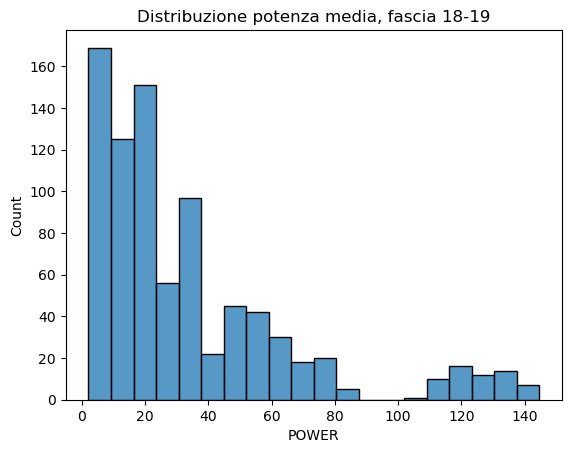

In [47]:
sns.histplot(df_night_trento['POWER'])
plt.title('Distribuzione potenza media, fascia 18-19')
plt.show()

In [48]:
len(df_night_trento[df_night_trento['POWER']>=20])

496

In [49]:
df_night_trento['HIGH_POW']=df_day_trento['HIGH_POW']

In [59]:
df_night_trento.to_csv('df_night_trento_nov.csv')

In [60]:
df_day.to_csv('df_day_nov.csv')

In [61]:
df_night.to_csv('df_night_nov.csv')

# Fascia oraria restrittiva

In [50]:
df_18_19=df_train[(df_train["MINUTE"] < 1140)&(df_train["MINUTE"] >1080)]
df_18_19=df_18_19.groupby(["SQUAREID",'DAY','DAY_ID','LUN', 'MAR', 'MER', 'GIO', 'VEN', 'SAB', 'DOM',"SQUARE_UBICAZIONI",'NR_LINES','DAWN','SUNSET','DAYLENGHT','minTemperature','maxTemperature'])["POWER"].mean().reset_index()
df_18_19

,SQUAREID,DAY,DAY_ID,LUN,MAR,MER,GIO,VEN,SAB,DOM,SQUARE_UBICAZIONI,NR_LINES,DAWN,SUNSET,DAYLENGHT,minTemperature,maxTemperature,POWER
0,155,1,4,0,0,0,0,1,0,0,4,1,417,1020,603,9.2,18.9,0.151583
1,155,2,5,0,0,0,0,0,1,0,4,1,418,1019,600,11.8,15.9,0.169391
2,155,3,6,0,0,0,0,0,0,1,4,1,419,1017,597,11.0,19.2,0.150609
3,155,4,0,1,0,0,0,0,0,0,4,1,421,1016,594,8.6,11.5,0.186226
4,155,5,1,0,1,0,0,0,0,0,4,1,422,1014,592,7.4,16.6,0.178226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59444,11099,26,1,0,1,0,0,0,0,0,3,1,451,993,541,-11.8,-3.7,0.312562
59445,11099,27,2,0,0,1,0,0,0,0,3,1,453,992,539,-12.4,-5.0,0.337077
59446,11099,28,3,0,0,0,1,0,0,0,3,1,454,992,538,-9.6,-0.4,0.338668
59447,11099,29,4,0,0,0,0,1,0,0,3,1,455,991,536,-7.1,1.2,0.351738


In [51]:
df_18_19_trento=df_18_19.merge(df_trento[['SQUAREID','TRENTO']],on='SQUAREID',how='left')
df_18_19_trento=df_18_19_trento[df_18_19_trento['TRENTO']==1]
df_18_19_trento

,SQUAREID,DAY,DAY_ID,LUN,MAR,MER,GIO,VEN,SAB,DOM,SQUARE_UBICAZIONI,NR_LINES,DAWN,SUNSET,DAYLENGHT,minTemperature,maxTemperature,POWER,TRENTO
23040,4850,1,4,0,0,0,0,1,0,0,285,5,417,1020,603,11.7,16.0,22.222965,1
23041,4850,2,5,0,0,0,0,0,1,0,285,5,418,1019,600,11.7,15.2,22.280760,1
23042,4850,3,6,0,0,0,0,0,0,1,285,5,419,1017,597,9.9,18.1,22.721294,1
23043,4850,4,0,1,0,0,0,0,0,0,285,5,421,1016,594,7.4,9.8,25.444795,1
23044,4850,5,1,0,1,0,0,0,0,0,285,5,422,1014,592,7.5,15.4,24.618746,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31915,5552,26,1,0,1,0,0,0,0,0,133,1,451,993,541,2.4,6.7,9.649588,1
31916,5552,27,2,0,0,1,0,0,0,0,133,1,453,992,539,-0.3,4.9,9.671775,1
31917,5552,28,3,0,0,0,1,0,0,0,133,1,454,992,538,-2.6,5.0,9.502905,1
31918,5552,29,4,0,0,0,0,1,0,0,133,1,455,991,536,-1.6,6.2,9.551594,1


In [52]:
df_18_19_trento['HIGH_POW']=df_day_trento['HIGH_POW']

In [53]:
df_18_19.to_csv('df_18_19_nov.csv')

In [54]:
df_18_19_trento.to_csv('df_18_19_trento_nov.csv')